In [1]:
# 실행결과 경고메시지 출력 제외
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import graphviz

from sklearn.tree import export_graphviz
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.api import Logit
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

matplotlib.rc("font", family="Malgun Gothic")

# 로지스틱 회귀분석

아래는 대출자들의 채무 상환과 관련된 데이터이다.  
상환 여부를 예측하기 위한 로지스틱 회귀분석을 실시하고 결과를 해석하시오.
- 데이터: HMEQ.CSV(변수: 13개, 자료 수: 3,748개)

In [2]:
df_raw=pd.read_csv("../data/HMEQ.csv")
df_raw.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1700,30548,40320.0,HomeImp,Other,9.0,0,0.0,101.466002,1.0,8,37.113614
1,1,1800,28502,43034.0,HomeImp,Other,11.0,0,0.0,88.766030,0.0,8,36.884894
2,0,2300,102370,120953.0,HomeImp,Office,2.0,0,0.0,90.992533,0.0,13,31.588503
3,1,2400,34863,47471.0,HomeImp,Mgr,12.0,0,0.0,70.491080,1.0,21,38.263601
4,0,2400,98449,117195.0,HomeImp,Office,4.0,0,0.0,93.811775,0.0,13,29.681827


In [3]:
df_raw.isnull().sum(axis=0)

BAD          0
LOAN         0
MORTDUE      0
VALUE       14
REASON       0
JOB         81
YOJ        205
DEROG        0
DELINQ      30
CLAGE       37
NINQ        56
CLNO         0
DEBTINC      0
dtype: int64

> Value는 14개의 결측치, JOB은 81개의 결측치, ... 등을 가짐

In [4]:
# JOB 변수의 결측치는 "Other"로 대체
# inplace: fillna 함수 적용 후 df_raw 데이터에 저장, false면 저장 안함
df_raw["JOB"].fillna("Other", inplace=True)
# 숫자형 변수의 결측치는 해당 변수의 평균값 입력: df_raw.mean() 각 변수별 평균 계산 후 결측치 대체
df_raw.fillna(df_raw.mean(), inplace=True)

In [5]:
# train_test_split(test_size=test 데이터 비율, random_state: random seed)
df_train, df_test=train_test_split(df_raw,test_size=0.3, random_state=1234)

print("train data size : {}".format(df_train.shape))
print("test data size : {}".format(df_test.shape))

train data size : (2623, 13)
test data size : (1125, 13)


> train 데이터 2,623간, test 데이터 1,125건

In [6]:
# from_formula 함수를 이용하여 변수 역할 지정
# 분석 대상 이벤트="1"
log_model=Logit.from_formula("""BAD~LOAN+MORTDUE+VALUE+C(REASON)+C(JOB)+YOJ+DEROG+DELINQ+CLAGE+NINQ+CLNO+DEBTINC""", df_train)

# 적합
log_result=log_model.fit()
# 결과 출력
print(log_result.summary())

Optimization terminated successfully.
         Current function value: 0.237614
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                    BAD   No. Observations:                 2623
Model:                          Logit   Df Residuals:                     2606
Method:                           MLE   Df Model:                           16
Date:                Mon, 08 Mar 2021   Pseudo R-squ.:                  0.2257
Time:                        17:06:13   Log-Likelihood:                -623.26
converged:                       True   LL-Null:                       -804.91
Covariance Type:            nonrobust   LLR p-value:                 1.743e-67
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -5.0942      0.560     -9.100      0.000      -6.191      -3.997

In [69]:
df_test.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
1721,0,16200,105502,117705.0,DebtCon,Other,0.0,0,0.0,125.242589,2.0,21,38.810662
822,0,11300,77846,101984.0,HomeImp,ProfExe,5.0,0,0.0,112.384846,1.0,27,28.298734
1686,1,16100,49371,77400.0,DebtCon,Office,3.0,2,2.0,214.060376,1.0,51,44.216764
789,0,11100,67366,102936.0,DebtCon,Other,9.0,0,0.0,213.281496,0.0,20,19.078651
165,0,6800,57439,74816.0,HomeImp,Mgr,2.0,0,2.0,126.303235,0.0,22,27.118654


In [7]:
# test 데이터 예측
y_pred=log_result.predict(df_test)
# 0과 1의 값을 가진 class로 변환
y_pred_class=(y_pred>0.5).astype(int)
y_pred_class.head()

1721    0
822     0
1686    0
789     0
165     0
dtype: int32

In [8]:
# 실제 test 데이터의 목표변수와 test 데이터의 예측값 비교
print("Accuracy: {0:.3f}\n".format(accuracy_score(df_test["BAD"], y_pred_class)))
print("Confustion Matrix: \n{}".format(confusion_matrix(df_test["BAD"], y_pred_class)))

Accuracy: 0.924

Confustion Matrix: 
[[1017    4]
 [  81   23]]


<AxesSubplot:>

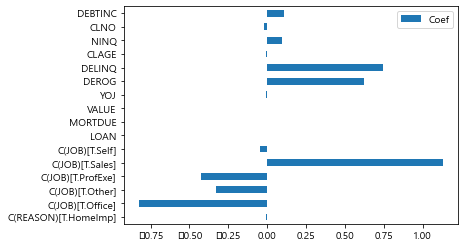

In [9]:
df_logistic_coef=pd.DataFrame({"Coef":log_result.params.values[1:]}, index=log_model.exog_names[1:])
df_logistic_coef.plot.barh(y="Coef")

> 직업이 Sales 이거나, 연체된 신용 한도의 수(DELINQ)와 심각한 연체 수(DEROG)가 높을 경우 대출 채무 불이행(BAD)일 가능성이 높아짐  

> 직업이 Office이면 대출 채무 불이행(BAD)일 가능성이 오히려 낮아짐

In [10]:
# select_dtypes: 특정 변수 타입을 선택/제외하여 데이터 추출
df_char=df_raw.select_dtypes(include="object")
df_numeric=df_raw.select_dtypes(exclude="object")

# Data Scaling
scaler=StandardScaler()
np_numeric_scaled=scaler.fit_transform(df_numeric)
df_numeric_scaled=pd.DataFrame(np_numeric_scaled, columns=df_numeric.columns)

# 문자 데이터 + 숫자 데이터
df_scaled=pd.concat([df_numeric_scaled, df_char], axis=1)
df_scaled.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON,JOB
0,3.140664,-1.559587,-0.993626,-1.224910,-0.017563,-0.267462,-0.342558,-0.967342,-0.018776,-1.428350,0.356347,HomeImp,Other
1,3.140664,-1.550817,-1.039240,-1.174897,0.251809,-0.267462,-0.342558,-1.122053,-0.666629,-1.428350,0.329025,HomeImp,Other
2,-0.318404,-1.506968,0.607570,0.260973,-0.960364,-0.267462,-0.342558,-1.094930,-0.666629,-0.905133,-0.303684,HomeImp,Office
3,3.140664,-1.498198,-0.897428,-1.093133,0.386495,-0.267462,-0.342558,-1.344679,-0.018776,-0.067985,0.493725,HomeImp,Mgr
4,-0.318404,-1.498198,0.520156,0.191721,-0.690992,-0.267462,-0.342558,-1.060586,-0.666629,-0.905133,-0.531456,HomeImp,Office


> BAD 변수도 scaling 적용(scale 대상에서 제외하거나 1/0로 재변환 필요)

In [11]:
# BAD 데이터를 0과 1로 변환, np.where(조건, 조건을 만족하는 경우, 만족하지 않는 경우)
df_scaled["BAD"]=np.where(df_scaled["BAD"]>0, 1, 0)
df_scaled.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON,JOB
0,1,-1.559587,-0.993626,-1.224910,-0.017563,-0.267462,-0.342558,-0.967342,-0.018776,-1.428350,0.356347,HomeImp,Other
1,1,-1.550817,-1.039240,-1.174897,0.251809,-0.267462,-0.342558,-1.122053,-0.666629,-1.428350,0.329025,HomeImp,Other
2,0,-1.506968,0.607570,0.260973,-0.960364,-0.267462,-0.342558,-1.094930,-0.666629,-0.905133,-0.303684,HomeImp,Office
3,1,-1.498198,-0.897428,-1.093133,0.386495,-0.267462,-0.342558,-1.344679,-0.018776,-0.067985,0.493725,HomeImp,Mgr
4,0,-1.498198,0.520156,0.191721,-0.690992,-0.267462,-0.342558,-1.060586,-0.666629,-0.905133,-0.531456,HomeImp,Office


In [12]:
# 데이터 분할
df_scaled_train, df_scaled_test=train_test_split(df_scaled, test_size=0.3, random_state=1234)

# from_formula 함수를 이용하여 변수 역할 지정
scaled_log_model=Logit.from_formula("""BAD~LOAN+MORTDUE+VALUE+C(REASON)+C(JOB)+YOJ+DEROG+DELINQ+CLAGE+NINQ+CLNO+DEBTINC""", df_scaled_train)

# 적합
scaled_log_result=scaled_log_model.fit()
# 결과 출력
print(scaled_log_result.summary())

Optimization terminated successfully.
         Current function value: 0.237614
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                    BAD   No. Observations:                 2623
Model:                          Logit   Df Residuals:                     2606
Method:                           MLE   Df Model:                           16
Date:                Mon, 08 Mar 2021   Pseudo R-squ.:                  0.2257
Time:                        17:06:14   Log-Likelihood:                -623.26
converged:                       True   LL-Null:                       -804.91
Covariance Type:            nonrobust   LLR p-value:                 1.743e-67
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -2.4815      0.205    -12.111      0.000      -2.883      -2.080

<AxesSubplot:>

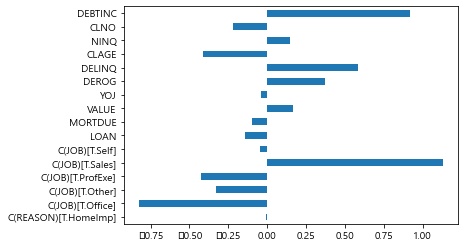

In [13]:
# 설명변수 중요도
df_log_scaled_coef=pd.DataFrame({"Coef":scaled_log_result.params.values[1:]},
                               index=scaled_log_model.exog_names[1:])
df_log_scaled_coef.plot.barh(y="Coef", legend=False)

> 직업이 Sales이거나, 부채비율 (DEBTINC)와 연체된 신용 한도의 수 (DELINQ)가 높을 경우 대출 채무 불이행(BAD)일 가능성이 높아짐  

> 특히 부채비율(DEBTINC)의 영향이 커짐  

> 직업이 OFFICE일 경우 대출 채무 불이행(BAD)일 가능성이 낮아짐

# 의사결정나무
아래는 대출자들의 채무 상환과 관련된 데이터이다.  
상환 여부를 예측하기 위한 의사결정나무 분석을 실시하고 결과를 해석하시오.  
- 데이터: HMEQ.CSV(변수: 13개, 자료 수: 3,748개)

In [14]:
df_raw=pd.read_csv("../data/HMEQ.csv")
df_raw.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1700,30548,40320.0,HomeImp,Other,9.0,0,0.0,101.466002,1.0,8,37.113614
1,1,1800,28502,43034.0,HomeImp,Other,11.0,0,0.0,88.766030,0.0,8,36.884894
2,0,2300,102370,120953.0,HomeImp,Office,2.0,0,0.0,90.992533,0.0,13,31.588503
3,1,2400,34863,47471.0,HomeImp,Mgr,12.0,0,0.0,70.491080,1.0,21,38.263601
4,0,2400,98449,117195.0,HomeImp,Office,4.0,0,0.0,93.811775,0.0,13,29.681827


In [15]:
df_raw.isnull().sum(axis=0)

BAD          0
LOAN         0
MORTDUE      0
VALUE       14
REASON       0
JOB         81
YOJ        205
DEROG        0
DELINQ      30
CLAGE       37
NINQ        56
CLNO         0
DEBTINC      0
dtype: int64

> Value는 14개의 결측치, JOB은 81개의 결측치, ... 등을 가짐

In [16]:
# JOB 변수의 결측치는 "Other"로 대체
# inplace: fillna 함수 적용 후 df_raw 데이터에 저장, false면 저장 안함
df_raw["JOB"].fillna("Other", inplace=True)
# 숫자형 변수의 결측치는 해당 변수의 평균값 입력: df_raw.mean() 각 변수별 평균 계산 후 결측치 대체
df_raw.fillna(df_raw.mean(), inplace=True)

In [17]:
# get_dummies: 데이터의 문자형 변수에 대한 더미변수 생성
df_raw_dummy=pd.get_dummies(df_raw)
# 더미변수 생성된 데이터의 상위 5개 row를 확인
df_raw_dummy.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_DebtCon,REASON_HomeImp,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,1,1700,30548,40320.0,9.0,0,0.0,101.466002,1.0,8,37.113614,0,1,0,0,1,0,0,0
1,1,1800,28502,43034.0,11.0,0,0.0,88.766030,0.0,8,36.884894,0,1,0,0,1,0,0,0
2,0,2300,102370,120953.0,2.0,0,0.0,90.992533,0.0,13,31.588503,0,1,0,1,0,0,0,0
3,1,2400,34863,47471.0,12.0,0,0.0,70.491080,1.0,21,38.263601,0,1,1,0,0,0,0,0
4,0,2400,98449,117195.0,4.0,0,0.0,93.811775,0.0,13,29.681827,0,1,0,1,0,0,0,0


In [18]:
# 목표변수, 설명변수 데이터 지정
df_raw_y=df_raw_dummy["BAD"]
df_raw_x=df_raw_dummy.drop("BAD", axis=1, inplace=False)

In [19]:
# train_test_split(X: 설명변수 데이터, Y: 목표변수 데이터, test_size=test 데이터 비율, random_state: random seed)
df_train_x, df_test_x, df_train_y, df_test_y=train_test_split(df_raw_x, df_raw_y, test_size=0.3, random_state=1234)
print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_y.shape))

train data X size : (2623, 18)
train data Y size : (2623,)
test data X size : (1125, 18)
test data Y size : (1125,)


In [20]:
tree_uncustomized=DecisionTreeClassifier(random_state=1234)
tree_uncustomized.fit(df_train_x, df_train_y)
# train 데이터 정확도
print("Accuracy on training set: {:.3f}".format(tree_uncustomized.score(df_train_x, df_train_y)))
# test 데이터 정확도
print("Accuracy on test set: {:.3f}".format(tree_uncustomized.score(df_test_x, df_test_y)))


Accuracy on training set: 1.000
Accuracy on test set: 0.932


> 모델 정확도는 train 100%, test 93.2%로 모델은 train 데이터에 과대적합

- max_depth: 최대 깊이 변경에 따른 모델 성능

In [21]:
# train 및 test 설명력 결과 저장
train_accuracy=[]; test_accuracy=[]
# min_samples_depth: 잎사귀 최소 자료 수
para_depth=[depth for depth in range(1, 11)]

for v_max_depth in para_depth:
    tree=DecisionTreeClassifier(random_state=1234, max_depth=v_max_depth)
    tree.fit(df_train_x, df_train_y)
    train_accuracy.append(tree.score(df_train_x, df_train_y))
    test_accuracy.append(tree.score(df_test_x, df_test_y))
    
# 결과 저장
df_accuracy_depth=pd.DataFrame()
df_accuracy_depth["Depth"]=para_depth
df_accuracy_depth["Trainaccuracy"]=train_accuracy
df_accuracy_depth["Testaccuracy"]=test_accuracy

# 모델 정확도 확인
df_accuracy_depth.round(3)

,Depth,Trainaccuracy,Testaccuracy
0,1,0.926,0.924
1,2,0.931,0.927
2,3,0.934,0.921
3,4,0.937,0.928
4,5,0.940,0.930
5,6,0.941,0.930
6,7,0.947,0.935
7,8,0.951,0.933
8,9,0.957,0.933
9,10,0.960,0.938


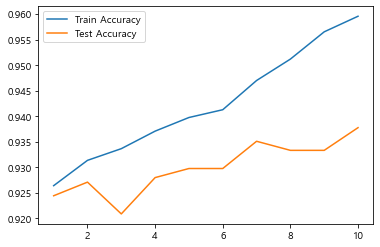

In [22]:
# 모델 정확도 그래프 확인
plt.plot(para_depth, train_accuracy, linestyle="-", label="Train Accuracy")
plt.plot(para_depth, test_accuracy, linestyle="-", label="Test Accuracy")
plt.legend()

> 최대 깊이 증가에 따라 모델의 정확도는 증가하며  
> Train/test 데이터의 성능 변화를 고려하여 4 선택

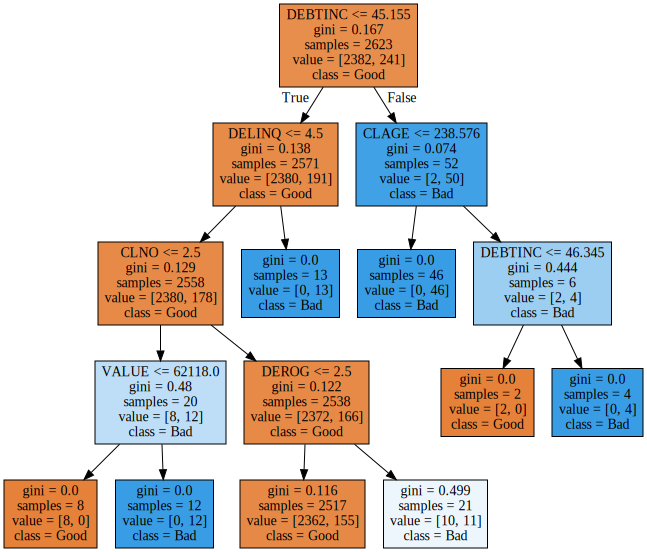

In [23]:
# 변수명 저장
v_feature_name=df_train_x.columns

# 깊이가 4인 모델
tree_low=DecisionTreeClassifier(max_depth=4, random_state=1234)
tree_low.fit(df_train_x, df_train_y)
# 트리 모델을 tree_low.dot 파일로 저장.
export_graphviz(tree_low, out_file="tree_low.dot", class_names=["Good", "Bad"], feature_names=v_feature_name, impurity=True, filled=True)
# graphviz를 이용해 트리 모델 시각화
with open("tree_low.dot") as f:
    dot_graph=f.read()
display(graphviz.Source(dot_graph))

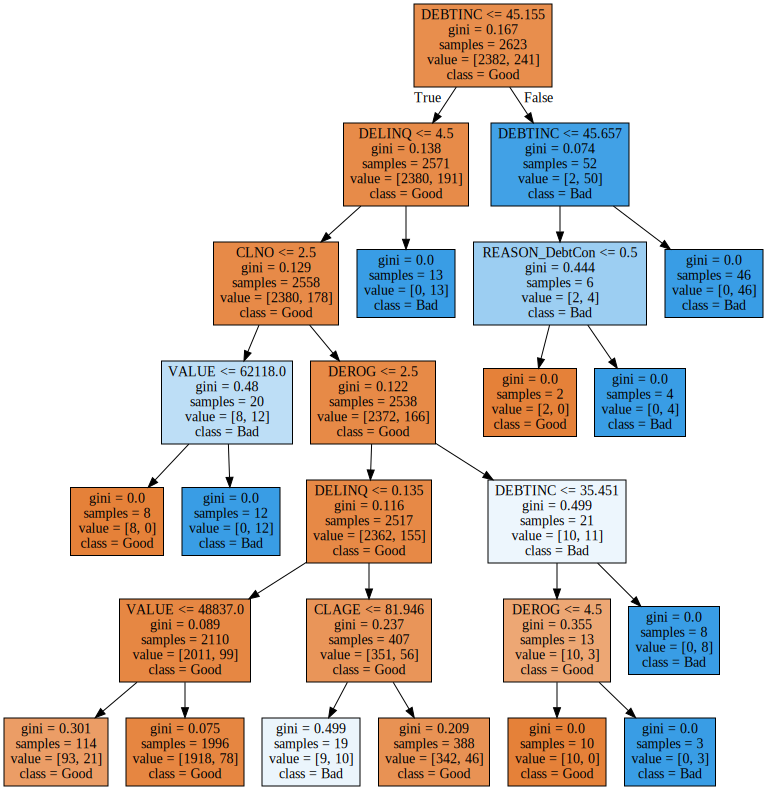

In [24]:
# 깊이가 6인 모델
tree_low=DecisionTreeClassifier(max_depth=6, random_state=1234)
tree_low.fit(df_train_x, df_train_y)
# 트리 모델을 tree_low.dot 파일로 저장.
export_graphviz(tree_low, out_file="tree_low.dot", class_names=["Good", "Bad"], feature_names=v_feature_name, impurity=True, filled=True)
# graphviz를 이용해 트리 모델 시각화
with open("tree_low.dot") as f:
    dot_graph=f.read()
display(graphviz.Source(dot_graph))

- min_samples_split: 분리 노드의 최소 자료 수 변경에 따른 모델 성능

In [25]:
# train 및 test 설명력 결과 저장
train_accuracy=[]; test_accuracy=[]
# min_samples_split: 잎사귀 최소 자료 수
para_split=[n_split*10 for n_split in range(1, 11)]

for v_min_samples_split in para_split:
    tree=DecisionTreeClassifier(random_state=1234, min_samples_split=v_min_samples_split, max_depth=4)
    tree.fit(df_train_x, df_train_y)
    train_accuracy.append(tree.score(df_train_x, df_train_y))
    test_accuracy.append(tree.score(df_test_x, df_test_y))
    
# 결과 저장
df_accuracy_split=pd.DataFrame()
df_accuracy_split["MinSamplesSplit"]=para_split
df_accuracy_split["Trainaccuracy"]=train_accuracy
df_accuracy_split["Testaccuracy"]=test_accuracy

# 모델 정확도 확인
df_accuracy_split.round(3)

,MinSamplesSplit,Trainaccuracy,Testaccuracy
0,10,0.936,0.928
1,20,0.936,0.928
2,30,0.933,0.921
3,40,0.933,0.921
4,50,0.933,0.921
5,60,0.933,0.921
6,70,0.933,0.921
7,80,0.933,0.921
8,90,0.933,0.921
9,100,0.933,0.921


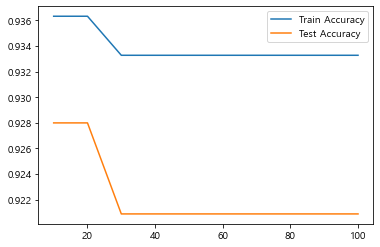

In [26]:
# 모델 정확도 그래프 확인
plt.plot(para_split, train_accuracy, linestyle="-", label="Train Accuracy")
plt.plot(para_split, test_accuracy, linestyle="-", label="Test Accuracy")
plt.legend()

> 분리 노듸의 최소 자료 수 증가에 따라 모델의 정확도는 감소하며  
> Train/test 데이터의 성능 변화를 고려하여 20 선택

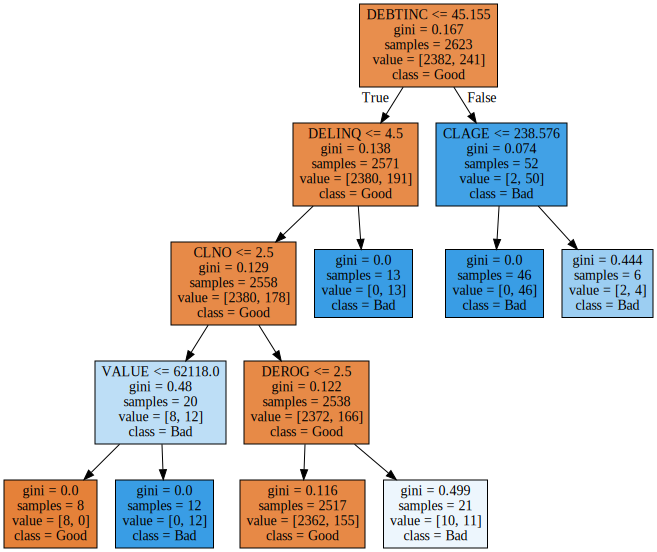

In [27]:
# 분리 노드의 최소 자료 수가 20인 모델
tree_low=DecisionTreeClassifier(max_depth=4, min_samples_split=20, random_state=1234)
tree_low.fit(df_train_x, df_train_y)
# 트리 모델을 tree_low.dot 파일로 저장.
export_graphviz(tree_low, out_file="tree_low.dot", class_names=["Good", "Bad"], feature_names=v_feature_name, impurity=True, filled=True)
# graphviz를 이용해 트리 모델 시각화
with open("tree_low.dot") as f:
    dot_graph=f.read()
display(graphviz.Source(dot_graph))

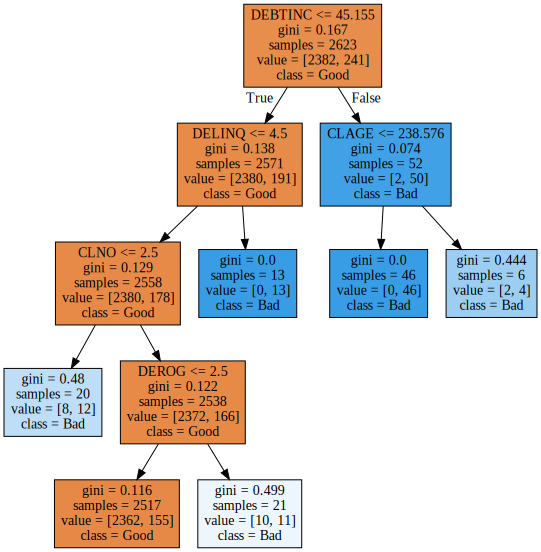

In [28]:
# 분리 노드의 최소 자료 수가 30인 모델
tree_low=DecisionTreeClassifier(max_depth=4, min_samples_split=30, random_state=1234)
tree_low.fit(df_train_x, df_train_y)
# 트리 모델을 tree_low.dot 파일로 저장.
export_graphviz(tree_low, out_file="tree_low.dot", class_names=["Good", "Bad"], feature_names=v_feature_name, impurity=True, filled=True)
# graphviz를 이용해 트리 모델 시각화
with open("tree_low.dot") as f:
    dot_graph=f.read()
display(graphviz.Source(dot_graph))

- min_samples_leaf: 잎사귀 노드의 최소 자료 수 변경에 따른 모델 성능

In [29]:
# train 및 test 설명력 결과 저장
train_accuracy=[]; test_accuracy=[]
# min_samples_leaf: 잎사귀 최소 자료 수
para_leaf=[n_leaf*2 for n_leaf in range(1, 11)]

for v_min_samples_leaf in para_leaf:
    tree=DecisionTreeClassifier(random_state=1234, min_samples_leaf=v_min_samples_leaf, min_samples_split=20, max_depth=4)
    tree.fit(df_train_x, df_train_y)
    train_accuracy.append(tree.score(df_train_x, df_train_y))
    test_accuracy.append(tree.score(df_test_x, df_test_y))
    
# 결과 저장
df_accuracy_leaf=pd.DataFrame()
df_accuracy_leaf["MinSamplesLeaf"]=para_leaf
df_accuracy_leaf["Trainaccuracy"]=train_accuracy
df_accuracy_leaf["Testaccuracy"]=test_accuracy

# 모델 정확도 확인
df_accuracy_leaf.round(3)

,MinSamplesLeaf,Trainaccuracy,Testaccuracy
0,2,0.936,0.928
1,4,0.936,0.928
2,6,0.936,0.928
3,8,0.936,0.928
4,10,0.936,0.928
5,12,0.933,0.921
6,14,0.932,0.917
7,16,0.932,0.919
8,18,0.932,0.919
9,20,0.932,0.919


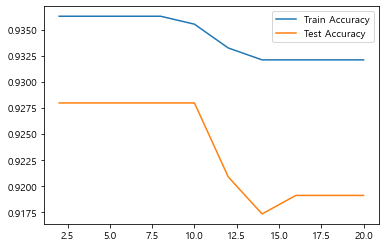

In [30]:
# 모델 정확도 그래프 확인
plt.plot(para_leaf, train_accuracy, linestyle="-", label="Train Accuracy")
plt.plot(para_leaf, test_accuracy, linestyle="-", label="Test Accuracy")
plt.legend()

> 잎사귀 노듸의 최소 자료 수 증가에 따라 모델의 정확도는 감소하며  
> Train/test 데이터의 성능 변화를 고려하여 10 선택  
> 분리 노드의 최소 자료 수를 20으로 선택했으므로 8 또는 10 선택 가능

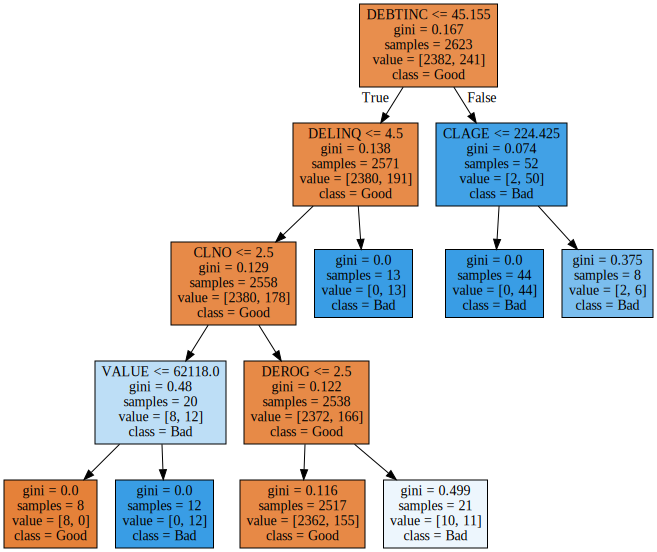

In [31]:
# 잎사귀 노드의 최소 자료 수가 8인 모델
tree_low=DecisionTreeClassifier(max_depth=4, min_samples_split=20, min_samples_leaf=8, random_state=1234)
tree_low.fit(df_train_x, df_train_y)
# 트리 모델을 tree_low.dot 파일로 저장.
export_graphviz(tree_low, out_file="tree_low.dot", class_names=["Good", "Bad"], feature_names=v_feature_name, impurity=True, filled=True)
# graphviz를 이용해 트리 모델 시각화
with open("tree_low.dot") as f:
    dot_graph=f.read()
display(graphviz.Source(dot_graph))

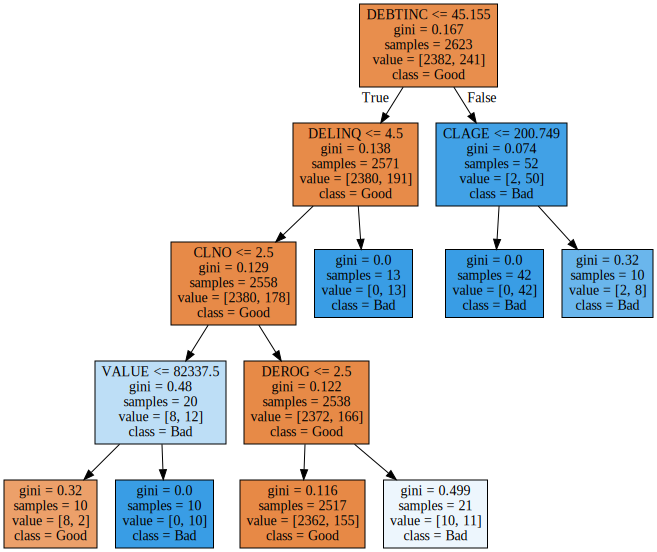

In [32]:
# 잎사귀 노드의 최소 자료 수가 10인 모델
tree_low=DecisionTreeClassifier(max_depth=4, min_samples_split=20, min_samples_leaf=10, random_state=1234)
tree_low.fit(df_train_x, df_train_y)
# 트리 모델을 tree_low.dot 파일로 저장.
export_graphviz(tree_low, out_file="tree_low.dot", class_names=["Good", "Bad"], feature_names=v_feature_name, impurity=True, filled=True)
# graphviz를 이용해 트리 모델 시각화
with open("tree_low.dot") as f:
    dot_graph=f.read()
display(graphviz.Source(dot_graph))

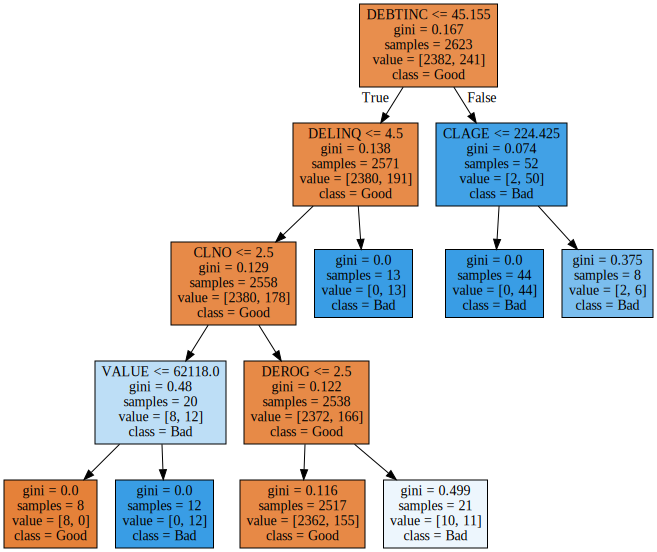

In [33]:
# 최종 모델
tree_final=DecisionTreeClassifier(random_state=1234, min_samples_leaf=8, min_samples_split=20, max_depth=4)
tree_final.fit(df_train_x, df_train_y)

# 최종 모델 시각화
export_graphviz(tree_final, out_file="tree_final.dot", class_names=["Good", "Bad"], feature_names=v_feature_name, impurity=True, filled=True)
with open("tree_final.dot") as f:
    dot_graph=f.read()
display(graphviz.Source(dot_graph))

In [34]:
# 평가
y_pred=tree_final.predict(df_test_x)
print("Accuracy: {0:.3f}\n".format(tree_final.score(df_test_x, df_test_y)))
print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

Accuracy: 0.928

Confusion matrix: 
[[1015    6]
 [  75   29]]


> 정분류율은 92.8%

In [35]:
# 결론 도출
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = tree_final.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("Importance", ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
9,DEBTINC,0.602
5,DELINQ,0.168
8,CLNO,0.085
2,VALUE,0.072
4,DEROG,0.067
6,CLAGE,0.006
12,JOB_Mgr,0.000
16,JOB_Sales,0.000
15,JOB_ProfExe,0.000
14,JOB_Other,0.000


Text(0, 0.5, '변수')

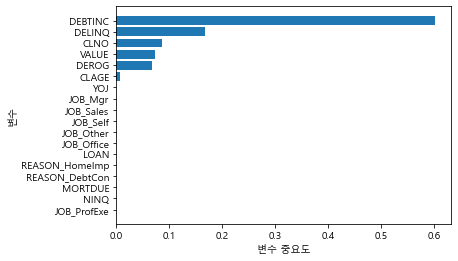

In [36]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위에 그림
df_importance.sort_values("Importance", ascending=True, inplace=True)
coordinates=range(len(df_importance))
plt.barh(y=coordinates, width=df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

> 중요 설명변수: 트리 생성 시 부채비율(DEBTINC), 연체된 신용 한도의 수(DELINQ) 순으로 영향이 크다고 해석할 수 있음  

> 단, 계산된 변수 중요도 값이 낮거나 0이더라도 선택되는 훈련 데이터에 따라   
중요도는 변경될 수 있음

- GridSearchCV를 이용한 최적 parameter 찾기

In [37]:
estimator=DecisionTreeClassifier()
# 구하고자 하는 parameter와 범위
param_grid={"max_depth":para_depth, "min_samples_split":para_split, "min_samples_leaf":para_leaf}
# 설명력이 높은 최적 parameter 찾기
grid_dt = GridSearchCV(estimator, param_grid, scoring="accuracy", n_jobs=-1)
grid_dt.fit(df_train_x, df_train_y)

print("best estimator model: \n{}".format(grid_dt.best_estimator_))
print("\nbest parameter: \n{}".format(grid_dt.best_params_))
print("\nbest score: \n{}".format(grid_dt.best_score_.round(3)))

best estimator model: 
DecisionTreeClassifier(max_depth=9, min_samples_leaf=4, min_samples_split=10)

best parameter: 
{'max_depth': 9, 'min_samples_leaf': 4, 'min_samples_split': 10}

best score: 
0.936


# 의사결정나무_실습
아래는 통신회사의 고객 이탈 데이터이다.  
고객의 이탈 여부를 예측하기 위한 의사결정나무 분석을 실시하고 결과를 해석하시오.  
- 데이터: 통신고객이탈.CSV(변수: 15개, 자료 수: 930개)

In [38]:
df_raw = pd.read_csv("../data/통신고객이탈.CSV" , engine = "python")
df_raw.head()

,CHURN,CUSTOMER_ID,GENDER,AGE,CHARGE_TYPE,HANDSET,USAGE_BAND,SERVICE_DURATION,DROPPED_CALLS,PEAK_CALLS_NO,PEAK_CALLS_TIME,WEEKEND_CALLS_NO,WEEKEND_CALLS_TIME,TOTAL_CALLS_NO,TOTAL_CALLS_TIME
0,Active,K102990,F,31,CAT 100,ASAD170,Med,33.33,6,218,379.8,9,21.6,366,632.4
1,Active,K103280,M,27,CAT 100,S50,Med,30.87,10,373,656.4,11,28.0,411,810.4
2,Active,K103660,M,27,CAT 100,ASAD170,Med,49.40,11,260,582.0,0,0.0,265,614.1
3,Active,K103730,M,61,CAT 100,ASAD170,Med,48.60,1,294,661.8,14,101.5,326,844.0
4,Active,K104560,F,52,CAT 100,S50,Med,56.03,0,221,555.6,7,25.0,274,673.0


#### 결측치 확인

In [39]:
df_raw.isnull().sum(axis = 0)

CHURN                 0
CUSTOMER_ID           0
GENDER                0
AGE                   0
CHARGE_TYPE           0
HANDSET               0
USAGE_BAND            0
SERVICE_DURATION      0
DROPPED_CALLS         0
PEAK_CALLS_NO         0
PEAK_CALLS_TIME       0
WEEKEND_CALLS_NO      0
WEEKEND_CALLS_TIME    0
TOTAL_CALLS_NO        0
TOTAL_CALLS_TIME      0
dtype: int64

#### 더미변수 생성

In [40]:
# drop: X변수외 변수 삭제
df_raw_x = df_raw.drop(["CHURN","CUSTOMER_ID"], axis = 1, inplace = False)

# get_dummies: 데이터의 문자형 변수에 대한 더미변수 생성 
df_raw_dummy = pd.get_dummies(df_raw_x)

# 더미변수 생성된 데이터의 상위 5개 row를 확인
df_raw_dummy.head()

,AGE,SERVICE_DURATION,DROPPED_CALLS,PEAK_CALLS_NO,PEAK_CALLS_TIME,WEEKEND_CALLS_NO,WEEKEND_CALLS_TIME,TOTAL_CALLS_NO,TOTAL_CALLS_TIME,GENDER_F,...,HANDSET_S80,HANDSET_SOP10,HANDSET_SOP20,HANDSET_WC95,USAGE_BAND_High,USAGE_BAND_Low,USAGE_BAND_Med,USAGE_BAND_MedHigh,USAGE_BAND_MedLow,USAGE_BAND_None
0,31,33.33,6,218,379.8,9,21.6,366,632.4,1,...,0,0,0,0,0,0,1,0,0,0
1,27,30.87,10,373,656.4,11,28.0,411,810.4,0,...,0,0,0,0,0,0,1,0,0,0
2,27,49.40,11,260,582.0,0,0.0,265,614.1,0,...,0,0,0,0,0,0,1,0,0,0
3,61,48.60,1,294,661.8,14,101.5,326,844.0,0,...,0,0,0,0,0,0,1,0,0,0
4,52,56.03,0,221,555.6,7,25.0,274,673.0,1,...,0,0,0,0,0,0,1,0,0,0


#### 변수 역할 지정

In [41]:
df_raw_y = df_raw["CHURN"] 
df_x_dummy = pd.get_dummies(df_raw_x)
df_raw_y = np.where(df_raw_y == "Active", 0, 1)

In [42]:
df_x_dummy.head()

,AGE,SERVICE_DURATION,DROPPED_CALLS,PEAK_CALLS_NO,PEAK_CALLS_TIME,WEEKEND_CALLS_NO,WEEKEND_CALLS_TIME,TOTAL_CALLS_NO,TOTAL_CALLS_TIME,GENDER_F,...,HANDSET_S80,HANDSET_SOP10,HANDSET_SOP20,HANDSET_WC95,USAGE_BAND_High,USAGE_BAND_Low,USAGE_BAND_Med,USAGE_BAND_MedHigh,USAGE_BAND_MedLow,USAGE_BAND_None
0,31,33.33,6,218,379.8,9,21.6,366,632.4,1,...,0,0,0,0,0,0,1,0,0,0
1,27,30.87,10,373,656.4,11,28.0,411,810.4,0,...,0,0,0,0,0,0,1,0,0,0
2,27,49.40,11,260,582.0,0,0.0,265,614.1,0,...,0,0,0,0,0,0,1,0,0,0
3,61,48.60,1,294,661.8,14,101.5,326,844.0,0,...,0,0,0,0,0,0,1,0,0,0
4,52,56.03,0,221,555.6,7,25.0,274,673.0,1,...,0,0,0,0,0,0,1,0,0,0


#### train, test 데이터 분할

In [43]:
# train_test_split(X: 설명변수 데이터, Y: 목표변수 데이터, test_size = test 데이터 비율, random_state: 랜덤)
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_x_dummy, # 설명변수 데이터
                                                                df_raw_y, # 목표변수 데이터
                                                                test_size = 0.3, # test 데이터의 비율
                                                                random_state = 1234)  # random state

print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_y.shape))

train data X size : (651, 33)
train data Y size : (651,)
test data X size : (279, 33)
test data Y size : (279,)


## 의사결정나무 모델 생성

- GridSearchCV를 이용한 최적 parameter 찾기

In [44]:
estimator=DecisionTreeClassifier(random_state=1234)
# 구하고자 하는 parameter와 범위
param_grid={"max_depth":para_depth, "min_samples_split":para_split, "min_samples_leaf":para_leaf}
# 설명력이 높은 최적 parameter 찾기
grid_dt = GridSearchCV(estimator, param_grid, scoring="accuracy", n_jobs=-1)
grid_dt.fit(df_train_x, df_train_y)

print("best estimator model: \n{}".format(grid_dt.best_estimator_))
print("\nbest parameter: \n{}".format(grid_dt.best_params_))
print("\nbest score: \n{}".format(grid_dt.best_score_.round(3)))

best estimator model: 
DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, min_samples_split=10,
                       random_state=1234)

best parameter: 
{'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 10}

best score: 
0.897


## 최종 모델 선정, 시각화

#### 최종 모델

In [45]:
tree_final = DecisionTreeClassifier(max_depth = 5, min_samples_leaf = 10, min_samples_split = 10)
tree_final.fit(df_train_x, df_train_y)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, min_samples_split=10)

In [46]:
# 평가
y_pred = tree_final.predict(df_test_x)
print("Accuracy: {0:.3f}\n".format(tree_final.score(df_test_x, df_test_y)))
print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

Accuracy: 0.910

Confusion matrix: 
[[224  11]
 [ 14  30]]


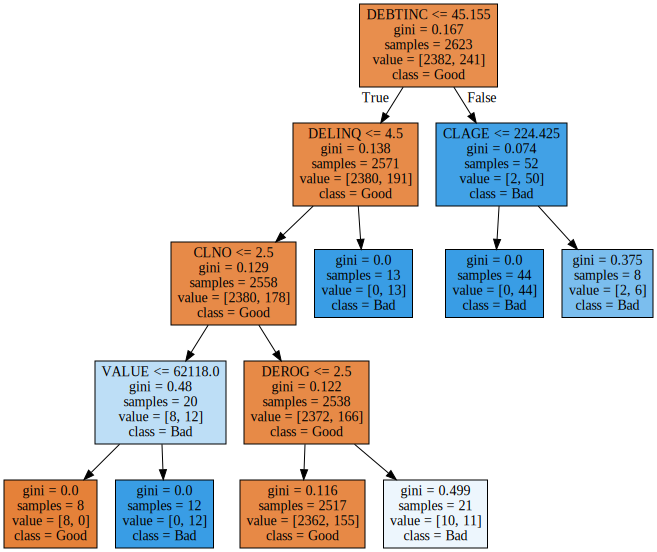

In [47]:
# 변수명 저장
feature_names=df_train_x.columns

# tree_final.dot으로 결과 저장
export_graphviz(tree_final, out_file="tree_fianl.dot", class_names = ["Active", "Churned"],
                feature_names = feature_names, impurity = True, filled = True)

# tree_final.dot 그리기
with open("tree_final.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

## 결론 도출

In [48]:
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = feature_names
df_importance["Importance"] = tree_final.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("Importance", ascending = False, inplace = True)
df_importance.round(3)

,Feature,Importance
17,HANDSET_ASAD90,0.342
2,DROPPED_CALLS,0.222
20,HANDSET_CAS30,0.166
4,PEAK_CALLS_TIME,0.120
8,TOTAL_CALLS_TIME,0.074
1,SERVICE_DURATION,0.042
0,AGE,0.033
28,USAGE_BAND_Low,0.000
29,USAGE_BAND_Med,0.000
19,HANDSET_BS210,0.000


Text(0, 0.5, '설명변수')

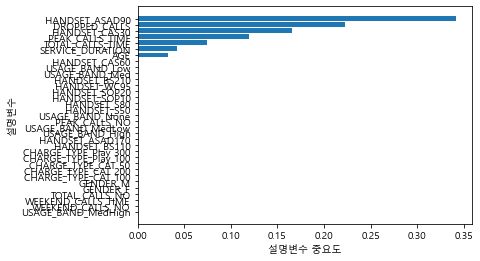

In [49]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위에 그림. 
df_importance.sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y = coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")


# 랜덤 포레스트
아래는 대출자들의 채무 상환과 관려된 데이터이다.  
상환 여부를 예측하기 위한 랜덤 포레스트 분석을 실시하고 결과를 해석하시오.  
- 데이터: HMEQ.CSV(변수: 13개, 자료 수: 3,748개)

In [50]:
df_raw=pd.read_csv("../data/HMEQ.csv")
df_raw.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1700,30548,40320.0,HomeImp,Other,9.0,0,0.0,101.466002,1.0,8,37.113614
1,1,1800,28502,43034.0,HomeImp,Other,11.0,0,0.0,88.766030,0.0,8,36.884894
2,0,2300,102370,120953.0,HomeImp,Office,2.0,0,0.0,90.992533,0.0,13,31.588503
3,1,2400,34863,47471.0,HomeImp,Mgr,12.0,0,0.0,70.491080,1.0,21,38.263601
4,0,2400,98449,117195.0,HomeImp,Office,4.0,0,0.0,93.811775,0.0,13,29.681827


In [51]:
df_raw.isnull().sum(axis=0)

BAD          0
LOAN         0
MORTDUE      0
VALUE       14
REASON       0
JOB         81
YOJ        205
DEROG        0
DELINQ      30
CLAGE       37
NINQ        56
CLNO         0
DEBTINC      0
dtype: int64

> Value는 14개의 결측치, JOB은 81개의 결측치, ... 등을 가짐

In [52]:
# JOB 변수의 결측치는 "Other"로 대체
# inplace: fillna 함수 적용 후 df_raw 데이터에 저장, false면 저장 안함
df_raw["JOB"].fillna("Other", inplace=True)
# 숫자형 변수의 결측치는 해당 변수의 평균값 입력: df_raw.mean() 각 변수별 평균 계산 후 결측치 대체
df_raw.fillna(df_raw.mean(), inplace=True)

In [53]:
# get_dummies: 데이터의 문자형 변수에 대한 더미변수 생성
df_raw_dummy=pd.get_dummies(df_raw)
# 더미변수 생성된 데이터의 상위 5개 row를 확인
df_raw_dummy.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_DebtCon,REASON_HomeImp,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,1,1700,30548,40320.0,9.0,0,0.0,101.466002,1.0,8,37.113614,0,1,0,0,1,0,0,0
1,1,1800,28502,43034.0,11.0,0,0.0,88.766030,0.0,8,36.884894,0,1,0,0,1,0,0,0
2,0,2300,102370,120953.0,2.0,0,0.0,90.992533,0.0,13,31.588503,0,1,0,1,0,0,0,0
3,1,2400,34863,47471.0,12.0,0,0.0,70.491080,1.0,21,38.263601,0,1,1,0,0,0,0,0
4,0,2400,98449,117195.0,4.0,0,0.0,93.811775,0.0,13,29.681827,0,1,0,1,0,0,0,0


In [54]:
# 목표변수, 설명변수 데이터 지정
df_raw_y=df_raw_dummy["BAD"]
df_raw_x=df_raw_dummy.drop("BAD", axis=1, inplace=False)

In [55]:
# train_test_split(X: 설명변수 데이터, Y: 목표변수 데이터, test_size=test 데이터 비율, random_state: random seed)
df_train_x, df_test_x, df_train_y, df_test_y=train_test_split(df_raw_x, df_raw_y, test_size=0.3, random_state=1234)
print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_y.shape))

train data X size : (2623, 18)
train data Y size : (2623,)
test data X size : (1125, 18)
test data Y size : (1125,)


In [56]:
tree_uncustomized=RandomForestClassifier(random_state=1234)
tree_uncustomized.fit(df_train_x, df_train_y)
# train 데이터 정확도
print("Accuracy on training set: {:.3f}".format(tree_uncustomized.score(df_train_x, df_train_y)))
# test 데이터 정확도
print("Accuracy on test set: {:.3f}".format(tree_uncustomized.score(df_test_x, df_test_y)))


Accuracy on training set: 1.000
Accuracy on test set: 0.946


> 모델 정확도는 train 100%, test 94.6%로 모델은 train 데이터에 과대적합

- n_estimators: 트리 수 변경에 따른 모델 성능

In [57]:
# train 및 test 설명력 결과 저장
train_accuracy=[]; test_accuracy=[]
# min_samples_n_tree: 잎사귀 최소 자료 수
para_n_tree=[n_tree*10 for n_tree in range(1, 16)]

for v_n_estimators in para_n_tree:
    tree=RandomForestClassifier(random_state=1234, n_estimators=v_n_estimators)
    tree.fit(df_train_x, df_train_y)
    train_accuracy.append(tree.score(df_train_x, df_train_y))
    test_accuracy.append(tree.score(df_test_x, df_test_y))
    
# 결과 저장
df_accuracy_n_tree=pd.DataFrame()
df_accuracy_n_tree["n_estimators"]=para_n_tree
df_accuracy_n_tree["Trainaccuracy"]=train_accuracy
df_accuracy_n_tree["Testaccuracy"]=test_accuracy

# 모델 정확도 확인
df_accuracy_n_tree.round(3)

,n_estimators,Trainaccuracy,Testaccuracy
0,10,0.992,0.944
1,20,0.999,0.943
2,30,0.999,0.942
3,40,1.000,0.946
4,50,1.000,0.944
5,60,1.000,0.948
6,70,1.000,0.947
7,80,1.000,0.947
8,90,1.000,0.946
9,100,1.000,0.946


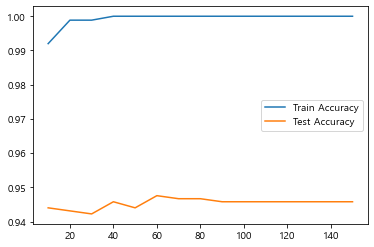

In [58]:
# 모델 정확도 그래프 확인
plt.plot(para_n_tree, train_accuracy, linestyle="-", label="Train Accuracy")
plt.plot(para_n_tree, test_accuracy, linestyle="-", label="Test Accuracy")
plt.legend()

> 생성하는 결정 트리 수 증가에 따라 모델의 정확도는 증가하며  

> Train/test 데이터의 성능 변화를 고려하여 40 선택  

> test 데이터의 성능 변화를 고려하여 60%을 선택할 수 있음  
> (단, train 데이터의 성능 변화가 없음)  

> OOB를 이용한 적정 나무 확인 가능

- n_estimators: 트리 수 변경에 따른 모델 oob error 변화

Text(0.5, 0, 'n_estimators')

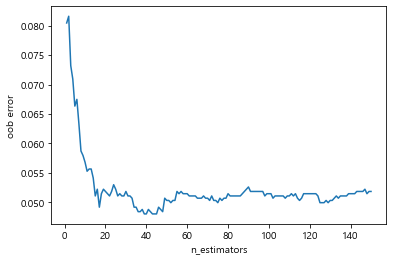

In [59]:
# error 저장 리스트
oob_error=[]

for v_n_estimator in range(1, 151):
    rf=RandomForestClassifier(n_estimators=v_n_estimator, oob_score=True, random_state=1234)
    rf.fit(df_train_x, df_train_y)
    oob_error.append(1-rf.oob_score_)
    
# 그래프로 표현
plt.plot(range(1, 151), oob_error)
plt.ylabel("oob error")
plt.xlabel("n_estimators")

> 생성하는 결정 트리 수 증가에 따라 모델의 정확도는 증가하며(OOB Error는 감소)  

> 모델의 특성을 고려하여 100 선택  
> (자료가 많은 경우에는 트리 수를 늘릴 수 있음)  

> 앞의 결과와 종합하여 40 선택 가능

- max_depth: 최대 깊이 변경에 따른 모델 성능

In [60]:
# train 및 test 설명력 결과 저장
train_accuracy=[]; test_accuracy=[]
# min_samples_depth: 잎사귀 최소 자료 수
para_depth=[depth for depth in range(1, 11)]

for v_max_depth in para_depth:
    rf=RandomForestClassifier(random_state=1234, max_depth=v_max_depth, n_estimators=100)
    rf.fit(df_train_x, df_train_y)
    train_accuracy.append(rf.score(df_train_x, df_train_y))
    test_accuracy.append(rf.score(df_test_x, df_test_y))
    
# 결과 저장
df_accuracy_depth=pd.DataFrame()
df_accuracy_depth["Depth"]=para_depth
df_accuracy_depth["Trainaccuracy"]=train_accuracy
df_accuracy_depth["Testaccuracy"]=test_accuracy

# 모델 정확도 확인
df_accuracy_depth.round(3)

,Depth,Trainaccuracy,Testaccuracy
0,1,0.908,0.908
1,2,0.912,0.910
2,3,0.932,0.928
3,4,0.933,0.930
4,5,0.938,0.931
5,6,0.941,0.932
6,7,0.945,0.934
7,8,0.949,0.936
8,9,0.951,0.935
9,10,0.956,0.938


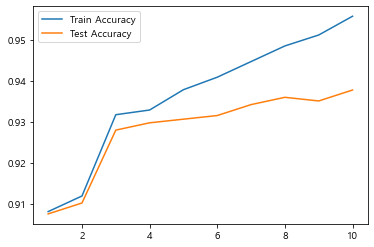

In [61]:
# 모델 정확도 그래프 확인
plt.plot(para_depth, train_accuracy, linestyle="-", label="Train Accuracy")
plt.plot(para_depth, test_accuracy, linestyle="-", label="Test Accuracy")
plt.legend()

> 최대 깊이 증가에 따라 모델의 정확도는 증가하며  
> Train/test 데이터의 성능 변화를 고려하여 4 선택

- min_samples_split: 분리 노드의 최소 자료 수 변경에 따른 모델 성능

In [62]:
# train 및 test 설명력 결과 저장
train_accuracy=[]; test_accuracy=[]
# min_samples_split: 잎사귀 최소 자료 수
para_split=[n_split*10 for n_split in range(1, 11)]

for v_min_samples_split in para_split:
    rf=RandomForestClassifier(random_state=1234, n_estimators=100, min_samples_split=v_min_samples_split, max_depth=4)
    rf.fit(df_train_x, df_train_y)
    train_accuracy.append(rf.score(df_train_x, df_train_y))
    test_accuracy.append(rf.score(df_test_x, df_test_y))
    
# 결과 저장
df_accuracy_split=pd.DataFrame()
df_accuracy_split["MinSamplesSplit"]=para_split
df_accuracy_split["Trainaccuracy"]=train_accuracy
df_accuracy_split["Testaccuracy"]=test_accuracy

# 모델 정확도 확인
df_accuracy_split.round(3)

,MinSamplesSplit,Trainaccuracy,Testaccuracy
0,10,0.933,0.929
1,20,0.933,0.929
2,30,0.932,0.929
3,40,0.933,0.929
4,50,0.932,0.929
5,60,0.932,0.929
6,70,0.932,0.929
7,80,0.932,0.928
8,90,0.932,0.928
9,100,0.932,0.928


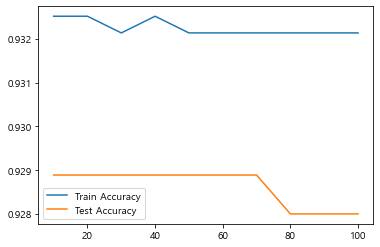

In [63]:
# 모델 정확도 그래프 확인
plt.plot(para_split, train_accuracy, linestyle="-", label="Train Accuracy")
plt.plot(para_split, test_accuracy, linestyle="-", label="Test Accuracy")
plt.legend()

> 분리 노드의 최소 자료 수 증가에 따라 모델의 정확도는 감소하나  
> test 데이터의 성능 변화를 고려하면 80까지는 영향이 없으며 80은 자료 수가 커서 특정 값을지정하지 않음

- min_samples_leaf: 잎사귀 노드의 최소 자료 수 변경에 따른 모델 성능

In [64]:
# train 및 test 설명력 결과 저장
train_accuracy=[]; test_accuracy=[]
# min_samples_leaf: 잎사귀 최소 자료 수
para_leaf=[n_leaf*10 for n_leaf in range(1, 11)]

for v_min_samples_leaf in para_leaf:
    rf=RandomForestClassifier(random_state=1234, min_samples_leaf=v_min_samples_leaf,n_estimators=100, max_depth=4)
    rf.fit(df_train_x, df_train_y)
    train_accuracy.append(rf.score(df_train_x, df_train_y))
    test_accuracy.append(rf.score(df_test_x, df_test_y))
    
# 결과 저장
df_accuracy_leaf=pd.DataFrame()
df_accuracy_leaf["MinSamplesLeaf"]=para_leaf
df_accuracy_leaf["Trainaccuracy"]=train_accuracy
df_accuracy_leaf["Testaccuracy"]=test_accuracy

# 모델 정확도 확인
df_accuracy_leaf.round(3)

,MinSamplesLeaf,Trainaccuracy,Testaccuracy
0,10,0.930,0.928
1,20,0.927,0.925
2,30,0.927,0.924
3,40,0.920,0.916
4,50,0.908,0.908
5,60,0.908,0.908
6,70,0.908,0.908
7,80,0.908,0.908
8,90,0.908,0.908
9,100,0.908,0.908


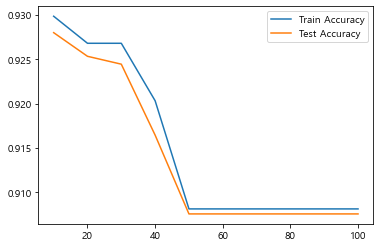

In [65]:
# 모델 정확도 그래프 확인
plt.plot(para_leaf, train_accuracy, linestyle="-", label="Train Accuracy")
plt.plot(para_leaf, test_accuracy, linestyle="-", label="Test Accuracy")
plt.legend()

> 잎사귀 노듸의 최소 자료 수 증가에 따라 모델의 정확도는 감소하며  
> Train/test 데이터의 성능 변화를 고려하여 20 선택  

In [66]:
# 최종 모델
rf_final=RandomForestClassifier(random_state=1234, min_samples_leaf=8, min_samples_split=20, max_depth=4)
rf_final.fit(df_train_x, df_train_y)

# 평가
y_pred=rf_final.predict(df_test_x)
print("Accuracy on training set: {0:.3f}\n".format(rf_final.score(df_train_x, df_train_y)))
print("Accuracy on test set: {0:.3f}\n".format(rf_final.score(df_test_x, df_test_y)))
print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

Accuracy on training set: 0.932

Accuracy on test set: 0.929

Confusion matrix: 
[[1021    0]
 [  80   24]]


> train/test 데이터의 정분류율이 비슷한 수준(92.7%)으로 안정적인 모델임을 확인할 수 있음.

In [67]:
# 변수명 저장
v_feature_name=df_train_x.columns

# 결론 도출
# rf.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = rf_final.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬
df_importance.sort_values("Importance", ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
9,DEBTINC,0.480
5,DELINQ,0.187
4,DEROG,0.071
8,CLNO,0.068
6,CLAGE,0.045
7,NINQ,0.041
0,LOAN,0.040
2,VALUE,0.027
1,MORTDUE,0.015
3,YOJ,0.008


Text(0, 0.5, '변수')

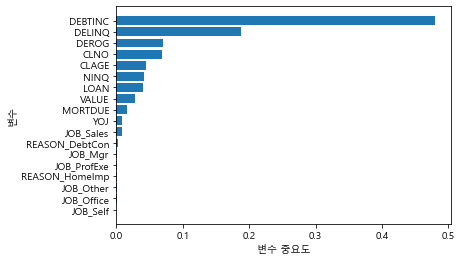

In [68]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위에 그림
df_importance.sort_values("Importance", ascending=True, inplace=True)
coordinates=range(len(df_importance))
plt.barh(y=coordinates, width=df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

> 중요 설명변수: 트리 생성 시 부채비율(DEBTINC), 연체된 신용 한도의 수(DELINQ) 순으로 영향이 크다고 해석할 수 있음  

> 단, 계산된 변수 중요도 값이 낮거나 0이더라도 선택되는 훈련 데이터에 따라   
중요도는 변경될 수 있음